## Setup

#### Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Camera Calibration

In [2]:
images =  [mpimg.imread('camera_cal/' + file) for file in os.listdir('camera_cal')]
patternSize = (9,6)
objpoints = []
imgpoints = []
for image in images:
    gray = cv2.cvtColor(image ,cv2.COLOR_RGB2GRAY)
    retval, corners = cv2.findChessboardCorners(gray, patternSize)
    if retval:
        objpoints.append(np.float32([(x,y,0) for y in range(patternSize[1]) for x in range(patternSize[0])]))
        imgpoints.append(np.float32([corner[0] for corner in corners]))

ret, camera_matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

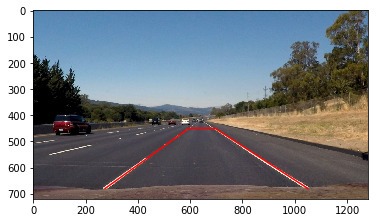

In [3]:
test_images = [mpimg.imread('test_images/' + filename) for filename in os.listdir('test_images')]
for image in test_images[2:]:
    plt.figure()
    plt.imshow(image)
    points = [[275, 680], [595, 450], [695, 450], [1050, 680]]
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    plt.plot(x, y, color='red')
    break

In [223]:
def polyfit(warped):
    # Use peaks of column activations to determine lane start points
    colsums = np.sum(warped, axis=0)
    midpoint = warped.shape[1] // 2
    left_current = np.argmax(colsums[0:midpoint])
    right_current = np.argmax(colsums[midpoint:]) + midpoint
    
    # Use sliding windows to identify lane points
    nwindows = 10
    window_height = warped.shape[0] // nwindows
    left_points = []
    right_points = []
    margin = 150
    for n in range(nwindows, 0, -1):
        bottom = window_height * n
        top = window_height * (n-1)
        left_box = warped[top:bottom, left_current - margin: left_current + margin]
        right_box = warped[top:bottom, right_current - margin: right_current + margin]
        lefts = np.transpose(np.nonzero(left_box)) + [top, left_current - margin]
        rights = np.transpose(np.nonzero(right_box)) + [top, right_current - margin]
        left_points.append(lefts)
        right_points.append(rights)
        if len(lefts) > 0:
            left_current = int(np.mean(lefts[:,1]))
        if len(rights) > 0:
            right_current = int(np.mean(rights[:,1]))
    left_points = np.concatenate(left_points)
    right_points = np.concatenate(right_points)
    
    # Fit a polynomial to the lane points
    left_poly = np.polyfit(left_points[:,0], left_points[:,1], 2)
    right_poly = np.polyfit(right_points[:,0], right_points[:,1],2)
    
    return left_poly, right_poly, left_points, right_points

def world_polyfit(points, meters_per_pixel):  
    world_points = points * meters_per_pixel
    world_poly = np.polyfit(world_points[:,0], world_points[:,1], 2)
    return world_points, world_poly
    
def radius_curvature(poly, y):
    A = poly[0]
    B = poly[1]
    C = poly[2]
    dx_dy = 2*A*y + B
    d2x_dy2 = 2*A
    return (1 + dx_dy**2)**1.5 / abs(d2x_dy2)

def threshold_image(image):
    red = image[:,:,0]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    saturation = hls[:,:,2]
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)
    
    saturation_sobelx = cv2.Sobel(saturation, cv2.CV_64F, 1, 0, ksize=5)
    saturation_sobely = cv2.Sobel(saturation, cv2.CV_64F, 0, 1, ksize=5)
    saturation_sobel_mag = np.sqrt(saturation_sobelx**2 + saturation_sobely**2)
    
    binary = np.zeros_like(gray)
    search = ((scaled_sobel_mag > 120) | (saturation > 120)) & (red > 80) & (saturation_sobel_mag > 1000)
    binary[search] = 1
    
    return binary

def warp_image(image, invert=False):
    src = np.float32([[275, 680], [595, 450], [695, 450], [1050, 680]])
    dst = np.float32([[300, 720], [300, 0], [980, 0], [980, 720]])
    if invert:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (1280, 720))
    return warped

In [226]:
previous = ([0,0,0], [0,0,0], 0) # left poly, right poly, ROC
def pipeline(image):
    image = cv2.undistort(image, camera_matrix, distortion)
    binary = threshold_image(image)
    warped = warp_image(binary)
    
    left_poly, right_poly, left_points, right_points = polyfit(warped)
    left_calc = np.poly1d(left_poly)
    right_calc = np.poly1d(right_poly)
    
    # Radius of curvature
    lane_width_pixels = right_calc(720) - left_calc(720)
    meters_per_pixel = [30 / 720, 3.7 / lane_width_pixels] # [y,x]
    world_left_points, world_left_poly = world_polyfit(left_points, meters_per_pixel)
    world_right_points, world_right_poly = world_polyfit(right_points, meters_per_pixel)
    roc_left = radius_curvature(world_left_poly, 720)
    roc_right = radius_curvature(world_right_poly, 720)
    roc_diff = abs(roc_left - roc_right) / max(roc_right, roc_left)
    
    # draw curves onto image
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    left_poly_points = np.array([[left_calc(y), y] for y in np.arange(720)])
    right_poly_points = np.array([[right_calc(y), y] for y in np.arange(720,0,-1)])
    poly_points = np.concatenate((left_poly_points, right_poly_points))
    cv2.polylines(color_warp, np.int_([left_poly_points]), False, (0, 0, 255), 30)
    cv2.polylines(color_warp, np.int_([right_poly_points]), False, (255, 0, 0), 30)  
    cv2.fillPoly(color_warp, np.int_([poly_points]), (0, 255, 0))
    
    lane_unwarped = warp_image(color_warp, invert=True)
    result = cv2.addWeighted(lane_unwarped, 0.5, image, 1, 0)
    
    return result

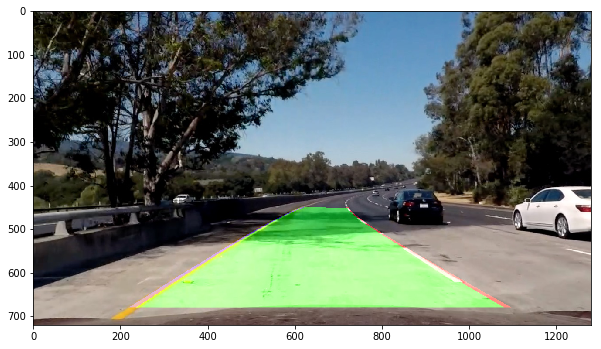

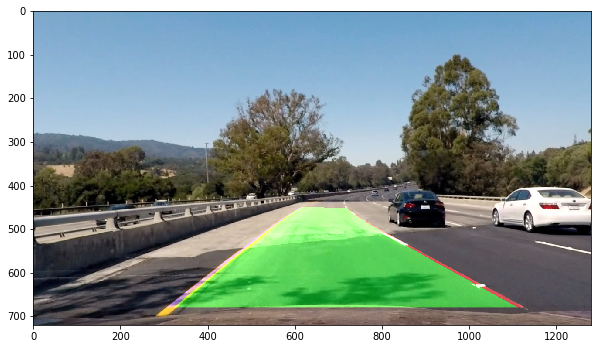

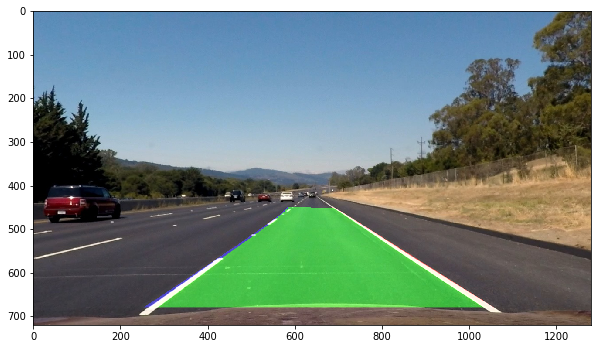

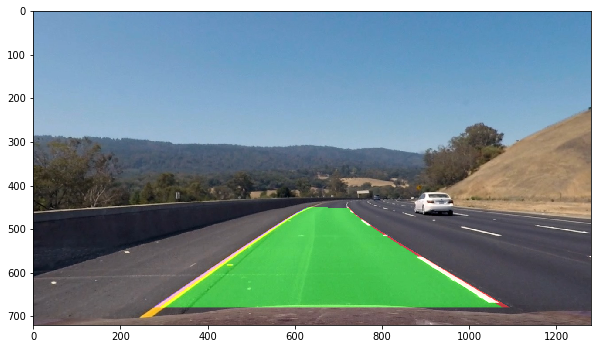

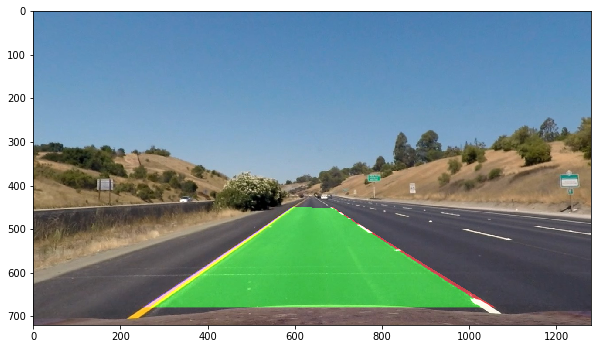

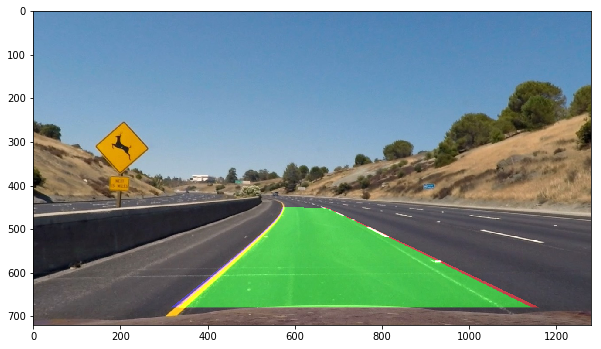

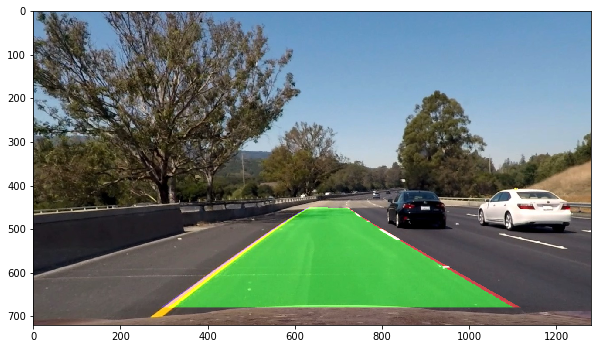

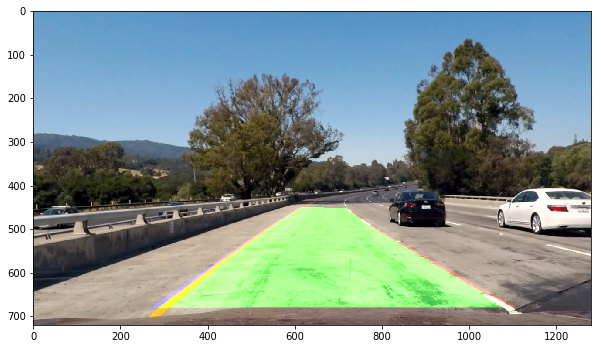

In [227]:
test_images = [mpimg.imread('test_images/' + filename) for filename in os.listdir('test_images')]
for i, image in enumerate(test_images):
    hard = (0,1,6,7)
    easy = (2,3,4,5)
    if i < 10:
        plt.figure(figsize=(10,15))
        plt.imshow(pipeline(image))

In [199]:
video = VideoFileClip('project_video.mp4')
processed_video = video.fl_image(pipeline).subclip(0,4)
%time processed_video.write_videofile('processed_video.mp4', audio=False)

[MoviePy] >>>> Building video processed_video.mp4
[MoviePy] Writing video processed_video.mp4


 99%|█████████▉| 100/101 [00:24<00:00,  3.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.mp4 

CPU times: user 35.6 s, sys: 716 ms, total: 36.3 s
Wall time: 25 s


In [190]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('processed_video.mp4'))